### Assignment 2

Deadline: 8 February.

**Question 1:** This question is about learning to use the VTK library. The idea is to implement a simple Grid class that allows to import triangle elements and vertices from vtk files and to export them to vtk files. The skeleton of the class is given as follows:

In [1]:
%matplotlib inline

import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pyopencl as cl
import vtk

In [2]:
class Grid(object):
    """This class implements access to triangular grids."""

    def __init__(self, vertices, elements):
        """
        Initialize a grid.

        This routine takes an Nx2 Numpy array of N vertices
        and a Mx3 Numpy array with corresponding M elements.
        """
        import numpy as np

        if not (isinstance(vertices, np.ndarray) and
                isinstance(elements, np.ndarray)):
            raise ValueError("The input data must be of type numpy.ndarray.")
        self.__vertices = vertices
        self.__elements = elements

        # Some protection against modifying the grid data externally
        self.__vertices.setflags(write=False)
        self.__elements.setflags(write=False)


    @classmethod
    def from_vtk_file(cls, filename):
        """Create a grid from a given vtk file."""

        if not os.path.isfile(filename):
             raise ValueError("File does not exist.")

        # Instantiate reader object, read data
        reader = vtk.vtkUnstructuredGridReader()
        reader.SetFileName(filename)
        reader.Update()

        # Read in all data from file
        data = reader.GetOutput()

        # Store metadata
        vertex_data = data.GetPoints()
        n_vertices = vertex_data.GetNumberOfPoints()
        n_cells = data.GetNumberOfCells()

        # Create buffers for data
        vertices_buffer = np.zeros(shape=(n_vertices, 2))
        elements_buffer = []

        for idx in range(n_vertices):
            vertices_buffer[idx, :] = vertex_data.GetPoint(idx)[:2]

        for idx in range(n_cells):
            cell = data.GetCell(idx)
            if cell.GetCellType() == vtk.VTK_TRIANGLE:
                elements_buffer.append(
                    np.array(
                        [
                            cell.GetPointId(0),
                            cell.GetPointId(1),
                            cell.GetPointId(2),
                        ]
                    )
                )

        elements_buffer = np.array(elements_buffer)

        return cls(vertices_buffer, elements_buffer)

    @property
    def number_of_vertices(self):
        """Return the number of vertices."""
        return self.__vertices.shape[0]

    @property
    def number_of_elements(self):
        """Return the number of elements."""
        return self.__elements.shape[0]

    @property
    def vertices(self):
        """Return the vertices."""
        return self.__vertices

    @property
    def elements(self):
        """Return the elements."""
        return self.__elements

    def get_corners(self, element_id):
        """Return the 2x3 matrix of corners associated with an element."""

        return self.__vertices[self.__elements[element_id, :], :]

    def get_jacobian(self, element_id):
        """Return the jacobian associated with a given element id."""
        corners = self.get_corners(element_id)
        a, b, c = corners[0], corners[1], corners[2]

        x_a, y_a = a[0], a[1]
        x_b, y_b = b[0], b[1]
        x_c, y_c = c[0], c[1]

        jacobian = [[x_b-x_a, y_b-y_a], [x_c-x_a, y_c-y_a]]

        return np.array(jacobian)
        
 
    def export_to_vtk(self, fname, point_data=None):
        """Export grid to a vtk file. Optionally also export point data."""
        from vtk import vtkUnstructuredGrid, vtkPointData, vtkDoubleArray, \
            vtkPoints, vtkUnstructuredGridWriter, VTK_TRIANGLE

        grid = vtkUnstructuredGrid()

        if point_data is not None:

            data = grid.GetPointData()
            scalar_data = vtkDoubleArray()
            scalar_data.SetNumberOfValues(len(point_data))
            for index, value in enumerate(point_data):
                scalar_data.SetValue(index, value)
            data.SetScalars(scalar_data)

        points = vtkPoints()
        points.SetNumberOfPoints(self.number_of_vertices)
        for index in range(self.number_of_vertices):
            points.InsertPoint(
                index,
                (self.vertices[index, 0], self.vertices[index, 1], 0))

        grid.SetPoints(points)

        for index in range(self.number_of_elements):
            grid.InsertNextCell(
                VTK_TRIANGLE, 3,
                [self.elements[index, 0], self.elements[index, 1],
                 self.elements[index, 2]]
            )

        writer = vtkUnstructuredGridWriter()
        writer.SetFileName(fname)
        writer.SetInputData(grid)
        writer.Write()

        return grid

Once you have implemented the grid class it is time to test it. For testing use the following commands.

In [3]:
grid = Grid.from_vtk_file('data/lshape.vtk')

In [4]:
print(grid.vertices[0])
print(grid.elements[50])
print(grid.get_corners(50))
print(grid.get_jacobian(50))

[-0.  0.]
[494 212 502]
[[0.96875 0.71875]
 [0.9375  0.6875 ]
 [0.96875 0.65625]]
[[-0.03125 -0.03125]
 [ 0.      -0.0625 ]]


**Question 2:**

We want to implement a finite difference method for the wave equation $u_{tt} = c^2u_{xx}$ for $c=1$ and $(t, x) \in [0, 1]\times [0, 2]$. The boundary conditions are $u(0, x) = e^{-5(x-.5)^2}$ and $\frac{\partial}{\partial n} u = 0$ otherwise.
The method should simply use central difference discretizations in space and time.

Your implementation should be written in OpenCL. Below you find a simple Numpy implementation that can serve as a template. Produce a plot of your result to demonstrate correctness.

In [5]:
def solve_wave_equation(N, time_steps, c=1, T=1):
    """
    Solves a 1d wave equation.

    This function solves the 1d wave equation
    with zero boundary conditions. The x-domain is the
    interval [0, 1] and the final time is T.
    """

    xt_grid = np.zeros((N, time_steps + 1), dtype='float64')
    xx = np.linspace(0, 1, N)

    # Set initial condition
    xt_grid[:, 0] = np.exp(-5 * (xx-.5)**2)
    

    dt = T / (1.0 * time_steps)
    dx = 1. / (N - 1)

    # Compute courant number
    C = c * dt / dx
    #print("Courant Number: {0}".format(C))

    # Set first step
    for index in range(0, N):
        il = 1 if index == 0 else index - 1
        ir = N - 2 if index == N - 1 else index + 1
        xt_grid[index, 1] = xt_grid[index, 0] - \
            .5 * C**2 * (xt_grid[ir, 0] - 2 * xt_grid[index, 0]
                + xt_grid[il, 0])

    # Compute the other steps
    for t_index in range(1, time_steps ):
        for x_index in range(0, N):
            il = 1 if x_index == 0 else x_index - 1
            ir = N - 2 if x_index == N - 1 else x_index + 1
            xt_grid[x_index, t_index + 1] = \
                (- xt_grid[x_index, t_index - 1] + 2 * xt_grid[x_index, t_index] +
                 C**2 * (xt_grid[ir, t_index] -
                 2 * xt_grid[x_index, t_index] +
                 xt_grid[il, t_index]))
    return xt_grid

#### Define OpenCL Kernel

In [6]:
KERNEL = """
__kernel void wave_eq_1D(__global float *u2,
                         __global const float *u1,
                         __global const float* u0,
                         float c,
                         float dt,
                         float dx)
{
    //Get total number of cells
    int nx = get_global_size(0);
    int idx = get_global_id(0);

    //Calculate the indices of our neighbouring cells
    int left;
    int right;

    if (idx == 0) {
        left = 1;
    }
    else {
        left = idx - 1;
    }
    if (idx == nx - 1) {
        right = nx - 1;
    }
    else {
        right = idx + 1;
    }

    u2[idx] = 2 * u1[idx] \
                    - u0[idx] \
                    + (c*c) \
                        * (dt * dt) / (dx * dx) \
                        * (u1[right] - 2 * u1[idx] + u1[left]);
}
"""

#### Write code for OpenCL simulation

In [7]:
def open_cl_setup():
    """Return objects required for interacting with OpenCL devices"""
    cl_ctx = cl.create_some_context()
    cl_queue = cl.CommandQueue(cl_ctx)
    mf = cl.mem_flags

    return cl_ctx, cl_queue, mf


def solve_wave_equation_cl(nx=200, nt=500, c=1, T=2, X=1):
    """
    Solve the 1D wave equation using OpenCL
    :param nx: The number of spatial steps
    :param nt: The number of temporal steps
    :param c: Wave speed
    :param T: Simulation time
    :param X: Spatial extent
    :return None:
    """
    cl_ctx, cl_queue, mf = open_cl_setup()
    # Calculate step size
    dx = X/(nx-1)
    dt = T/nt

    # Calculate Courant number
    C = c * (dt / dx)

    # CPU data
    xx = np.linspace(0, X, nx, dtype=np.float32)
    u0 = np.exp(-5*(xx-.5) ** 2)

    # Calculate first step
    u1 = np.zeros_like(u0, dtype=np.float32)
    for i in range(0, nx):
        il = 1 if i == 0 else i - 1
        ir = nx - 2 if i == nx - 1 else i + 1
        u1[i] = u0[i] - 0.5 * C**2 * (u0[ir] - 2*u0[i] + u0[il])

    # Upload data to the device
    U0_g = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
    U1_g = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u1)

    # Allocate output buffer
    U2_g = cl.Buffer(cl_ctx, mf.READ_WRITE, u1.nbytes)

    # Build Kernels
    prg = cl.Program(cl_ctx, KERNEL).build()
    wave_equation_1d = prg.wave_eq_1D

    res = [u0, u1]

    # Loop through all the timesteps
    for i in range(1, nt):
        kernel_args = (U2_g, U1_g, U0_g, np.float32(c), np.float32(dt), np.float32(dx))

        # Execute kernel on device with nx threads
        wave_equation_1d(cl_queue, (nx, 1), None, *kernel_args)

        u2 = np.empty(nx, dtype=np.float32)
        cl.enqueue_copy(cl_queue, u2, U2_g)
        res.append(u2)

        # Swap variables
        U0_g, U1_g, U2_g = U1_g, U2_g, U0_g

    res = np.array(res).T

    return res


def plot_simulation(nx=200, nt=500, c=1, T=2, X=1):
    """Plot OpenCL simulation experiment results"""

    start = time()
    res = solve_wave_equation_cl(nx, nt, c, T, X)
    print("OpenCL simulation time {:.2f} seconds".format(time()-start))

    plt.imshow(res, extent=[0, T, 0, X])
    plt.colorbar()
    plt.show()

##### Must run simulation a few times for OpenCL to 'warm up'

OpenCL simulation time 0.06 seconds


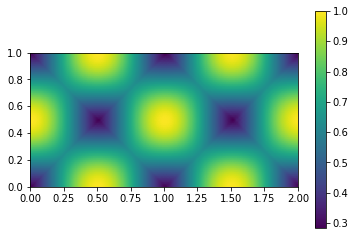

In [12]:
plot_simulation()

Numpy Simulation time 0.32 seconds
(200, 501)


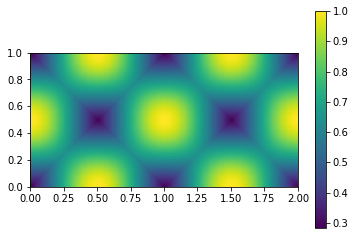

In [13]:
T = 2
st = time()
res = solve_wave_equation(200, 500, c=1, T=T)
et = time()
print("Numpy Simulation time {:.2f} seconds".format(et - st))
print(res.shape)
plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()